# **Semantic Segmentation**

####*Submitted by:* 
>> **_Usama Aleem Shami_**\
>> _Reg. No. : **329894**\
>> MSCS 2020_
####*Submitted to:* 
>> **_Dr. Muhammad Moazam Fraz_**\
>> _Advanced Computer Vision (CS-893)_

## Table of Contents

1. [Connecting Google Drive and Specifying Paths](#Gdrive)
2. [Installing and Importing Packages/Modules](#Package)
3. [Importing and Unzipping Dataset](#Data)
4. [GPU Details](#GPU)
5. [Defining Utility Functions](#Func)
      * [Custom Losses](#Loss)
      * [Custom Metrics](#Metric)
6. [Reading Images and Annotations](#Anno)
7. [UNet with VGG16](#VGG)
      * [Model Architecture](#img1)
      * [Model Training](#train1)
      * [Learning Curve Plots](#plot1)
      * [Model Predictions](#pred1)
      * [Performance Metrics](#pm1)
      * [Qualititative Results](#qual1)
8. [UNet with ResNet50](#ResNet)
      * [Model Architecture](#img2)
      * [Model Training](#train2)
      * [Learning Curve Plots](#plot2)
      * [Model Predictions](#pred2)
      * [Performance Metrics](#pm2)
      * [Qualititative Results](#qual2)

# Connecting Google Drive and Specifying Paths<a name="Gdrive"></a>

In [1]:
# Mounting Google Drive with Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Specifying Google Drive Path where Dataset is located
DATASET_PATH_GDRIVE = '/content/drive/MyDrive/ACV/Assignments/Asg3'

# Specifying Google Colab Path where Dataset is to be copied
DATASET_PATH_LOCAL = '/content/dataset'

#Installing and Importing Packages/Modules <a name="Package"></a>

In [3]:
! pip install -U segmentation-models

     |████████████████████████████████| 50 kB 7.3 MB/s 


In [ ]:
# !pip install keras-segmentation

In [4]:
import os
import numpy as np
import matplotlib 
import PIL
import sklearn
import tensorflow as tf
import keras
import cv2
import segmentation_models as sm


from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix, recall_score
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D
from keras.layers.merge import concatenate, add
from keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical

Segmentation Models: using `keras` framework.


In [6]:
# Displaying Versions of Installed Packages
!python --version 
print('Tensorflow Version:', tf.__version__)
print('Keras Version:', keras.__version__)
print('Numpy Version:', np.__version__)
print('OpenCV Version:', cv2.__version__)
print('Matplotlib Version:', matplotlib.__version__)
print('Pillow Version:', PIL.__version__)
print('Scikit Learn Version:', sklearn.__version__)

Python 3.7.13
Tensorflow Version: 2.8.0
Keras Version: 2.8.0
Numpy Version: 1.21.6
OpenCV Version: 4.1.2
Matplotlib Version: 3.2.2
Pillow Version: 7.1.2
Scikit Learn Version: 1.0.2


In [7]:
sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')
sm.framework()

'tf.keras'

# Importing and Unzipping Dataset <a name="Data"></a>

In [8]:
# Creating desired Directory in Google Colab WorkSpace
if not os.path.exists(DATASET_PATH_LOCAL):
  os.mkdir(DATASET_PATH_LOCAL)

# Copying .tar files from Google Drive to Google Colab WorkSpace
!cp $DATASET_PATH_GDRIVE/*.zip $DATASET_PATH_LOCAL # MUST mention the FILE NAME after GDrive Path

print ("Files Copied to Colab Workspace from GDrive, successfully!")

Files Copied to Colab Workspace from GDrive, successfully!


In [9]:
# Unzipping Dataset to Colab Workspace
!unzip -q $DATASET_PATH_LOCAL/A3_Dataset.zip -d $DATASET_PATH_LOCAL

print ("Dataset Unzipped to Colab Workspace, successfully!")

Dataset Unzipped to Colab Workspace, successfully!


# GPU Details <a name="GPU"></a>

In [10]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [11]:
!nvidia-smi

Sun May 22 17:37:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |    264MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Defining Utility Functions <a name="Utils"></a>

In [12]:
#Classes list excluding the background
CLASSES = ["Sky", "Building", "Pole", "Road", "Pavement", "Tree",
           "SignSymbol", "Fence", "Car", "Pedestrian", "Bicyclist"]

In [13]:
def getImages(imagePath):
  """
    This function reads/loads the images from a desired directory and returns the Image Data as a list
  """ 
  imageDir = os.listdir(imagePath)
  imageDir.sort()
  data = []

  for file in tqdm(imageDir): 
    image = Image.open(os.path.join(imagePath, file)).resize((256,256))
    # image = image/255
    image = np.array(image)
    # image = np.array(image).astype(np.float32)
    data.append(image)
  print("Images loaded")  

  return data

def getMasks(maskPath):
  """
    This function reads/loads the masks/annotations from a desired directory and returns the Mask Data as a list
  """ 
  maskDir = os.listdir(maskPath)
  maskDir.sort()
  data = []

  for file in tqdm(maskDir): 
    mask = Image.open(os.path.join(maskPath, file)).resize((256,256))
    mask = np.array(mask)
    # mask = np.array(mask).astype(np.float32)
    data.append(mask)
  print("Masks loaded")  

  return data

def getMasks_OHE(maskPath):
  """
    This function reads/loads the masks/annotations from a desired directory, converts into One Hot Encoding and returns the Mask Data as a list
  """ 
  maskDir = os.listdir(maskPath)
  maskDir.sort()
  data = []

  for file in tqdm(maskDir): 
    mask = Image.open(os.path.join(maskPath, file)).resize((256,256))
    mask = np.array(mask)
    # mask = np.array(mask).astype(np.float32)
    mask = tf.one_hot(mask, len(CLASSES)+1)
    data.append(mask)
  print("Masks loaded")  

  return data

###Custom Losses <a name="Loss"></a>

In [14]:
def dice_loss(y_true, y_pred):
    """
    Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)

    """
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))
    return 1 - numerator / denominator

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = |A∩B| / |A∪B| = TP / (TP + FP + FN)
    
    OR

    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))

    
    The jaccard distance loss is useful for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


### Custom Metrics <a name="Metric"></a>

In [15]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [16]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    

 # helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x   

In [17]:
def ComputePerformanceMetrics(TP,FP,TN,FN):
  
  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP) 
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  # Negative predictive value
  NPV = TN/(TN+FN)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  # False discovery rate
  FDR = FP/(TP+FP)

  # Overall accuracy
  ACC = (TP+TN)/(TP+FP+FN+TN)

  return TPR, TNR, PPV, NPV, FPR, FDR, ACC


def PerformanceMetrics(TPR,TNR,PPV,NPV):
  """
    This function prints the Performance Metrics by taking TPR, TNR, PPV, NPV
  """ 
  print('-----------------------')
  print("TPR:     %0.4f"% TPR)
  print("TNR:     %0.4f"% TNR)
  print("PPV:     %0.4f"% PPV)
  print("NPV:     %0.4f"% NPV)
  print('-----------------------')

In [13]:
# # Function to Construct and Plot Confusion Matrix
# def plotConfusionMatrix(y_true, y_pred, classes,
#                           normalize = False,
#                           title = None,
#                           cmap = plt.cm.Blues):
#   """
#     This function constructs Confusion Matrix by taking True and Predicted values, and an array of class labels 
#     as its input parameters
#   """ 
#   if not title:
#       if normalize:
#           title = 'Normalized Confusion Matrix'
#       else:
#           title = 'Confusion Matrix without Normalization'

#   cm = confusion_matrix(y_true, y_pred)
#   if normalize:
#       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#       print("Normalized Confusion Matrix")
#   else:
#       print('Confusion Matrix without Normalization')

#   print(cm)

#   fig, ax = plt.subplots()
#   im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#   ax.figure.colorbar(im, ax=ax)
#   ax.set(xticks=np.arange(cm.shape[1]),
#           yticks=np.arange(cm.shape[0]),
#           xticklabels=classes, yticklabels=classes,
#           title=title,
#           ylabel='True label',
#           xlabel='Predicted label')

#   plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#             rotation_mode="anchor")

#   fmt = '.2f' if normalize else 'd'
#   thresh = cm.max() / 2.
#   for i in range(cm.shape[0]):
#       for j in range(cm.shape[1]):
#           ax.text(j, i, format(cm[i, j], fmt),
#                   ha="center", va="center",
#                   color="white" if cm[i, j] > thresh else "black")
#   fig.tight_layout()
#   return ax


# # Function to Plot Confusion Matrices (With and Without Normalization)
# def plotConfusions(true, predictions):
#   """
#     This function plots the Confusion Matrices, with and without Normalizing the scores.
#   """ 
#   np.set_printoptions(precision = 2)

#   class_names = ["Sky", "Building", "Pole", "Road", "Pavement", "Tree","SignSymbol", "Fence", "Car", "Pedestrian", "Bicyclist, Background"]
#   #  where {0: Neutral, 1: Happy, 2: Sad, 3: Surprise, 4:Fear, 5: Disgust, 6: Anger, 7: Contempt}
  
#   plotConfusionMatrix(true, predictions, classes = class_names,
#                     title='Confusion Matrix without normalization')

#   plotConfusionMatrix(true, predictions, classes = class_names, normalize = True,
#                     title='Normalized Confusion Matrix')
#   plt.show()

#Reading Images and Annotations <a name="Anno"></a>

In [18]:
trainImagePath = os.path.join(DATASET_PATH_LOCAL,'images_prepped_train')
trainMaskPath = os.path.join(DATASET_PATH_LOCAL,'annotations_prepped_train')

valImagePath = os.path.join(DATASET_PATH_LOCAL,'images_prepped_validation')
valMaskPath = os.path.join(DATASET_PATH_LOCAL,'annotations_prepped_validation')

testImagePath = os.path.join(DATASET_PATH_LOCAL,'images_prepped_test')
testMaskPath = os.path.join(DATASET_PATH_LOCAL,'annotations_prepped_test')

In [19]:
x_train = getImages(trainImagePath)
y_train = getMasks(trainMaskPath)
y_train_OHE = getMasks_OHE(trainMaskPath)


x_val = getImages(valImagePath)
y_val = getMasks(valMaskPath)
y_val_OHE = getMasks_OHE(valMaskPath)

x_test = getImages(testImagePath)
y_test = getMasks(testMaskPath)
y_test_OHE = getMasks_OHE(testMaskPath)

  0%|          | 0/294 [00:00<?, ?it/s]

Images loaded


  0%|          | 0/294 [00:00<?, ?it/s]

Masks loaded


  0%|          | 0/294 [00:00<?, ?it/s]

Masks loaded


  0%|          | 0/73 [00:00<?, ?it/s]

Images loaded


  0%|          | 0/73 [00:00<?, ?it/s]

Masks loaded


  0%|          | 0/73 [00:00<?, ?it/s]

Masks loaded


  0%|          | 0/101 [00:00<?, ?it/s]

Images loaded


  0%|          | 0/101 [00:00<?, ?it/s]

Masks loaded


  0%|          | 0/101 [00:00<?, ?it/s]

Masks loaded


In [20]:
print('Train Set')
x_train = np.array(x_train)
print(x_train.shape)
y_train = np.array(y_train)
print(y_train.shape)
y_train_OHE = np.array(y_train_OHE)
print(y_train_OHE.shape)
print('\n')

print('Validation Set')
x_val = np.array(x_val)
print(x_val.shape)
y_val = np.array(y_val)
print(y_val.shape)
y_val_OHE = np.array(y_val_OHE)
print(y_val_OHE.shape)
print('\n')

print('Test Set')
x_test = np.array(x_test)
print(x_test.shape)
y_test = np.array(y_test)
print(y_test.shape)
y_test_OHE = np.array(y_test_OHE)
print(y_test_OHE.shape)

Train Set
(294, 256, 256, 3)
(294, 256, 256)
(294, 256, 256, 12)


Validation Set
(73, 256, 256, 3)
(73, 256, 256)
(73, 256, 256, 12)


Test Set
(101, 256, 256, 3)
(101, 256, 256)
(101, 256, 256, 12)


##UNet with VGG16 <a name="VGG"></a>

In [21]:
BATCH_SIZE = 16
EPOCHS = 40
LR = 0.0001
# Height and Width set to 256, in helper functions (used to fetch images)

In [22]:
BACKBONE = 'vgg16'
#create model with backbone VGG16
model1 = sm.Unet(BACKBONE, classes=len(CLASSES)+1, activation='softmax', encoder_weights=None,  decoder_use_batchnorm=True)

In [23]:
model1.compile(
    optimizer = Adam(learning_rate=LR, amsgrad=True),
    loss = dice_loss,
    metrics = [
               dice_coef,
               'accuracy',
               keras.metrics.TruePositives(name='tp'),
               keras.metrics.FalsePositives(name='fp'),
               keras.metrics.TrueNegatives(name='tn'),
               keras.metrics.FalseNegatives(name='fn')
               ]
    )

callbacks = [
             ModelCheckpoint(os.path.join(DATASET_PATH_GDRIVE,'model_unet_vgg16.h5'), monitor='val_dice_coef', mode= 'max', save_weights_only=True, save_best_only=True),
             CSVLogger(os.path.join(DATASET_PATH_GDRIVE,'train_logs_unet_vgg16.csv')),    
             ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
             ]

In [24]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                           

##Model Architecture <a name="img1"></a>

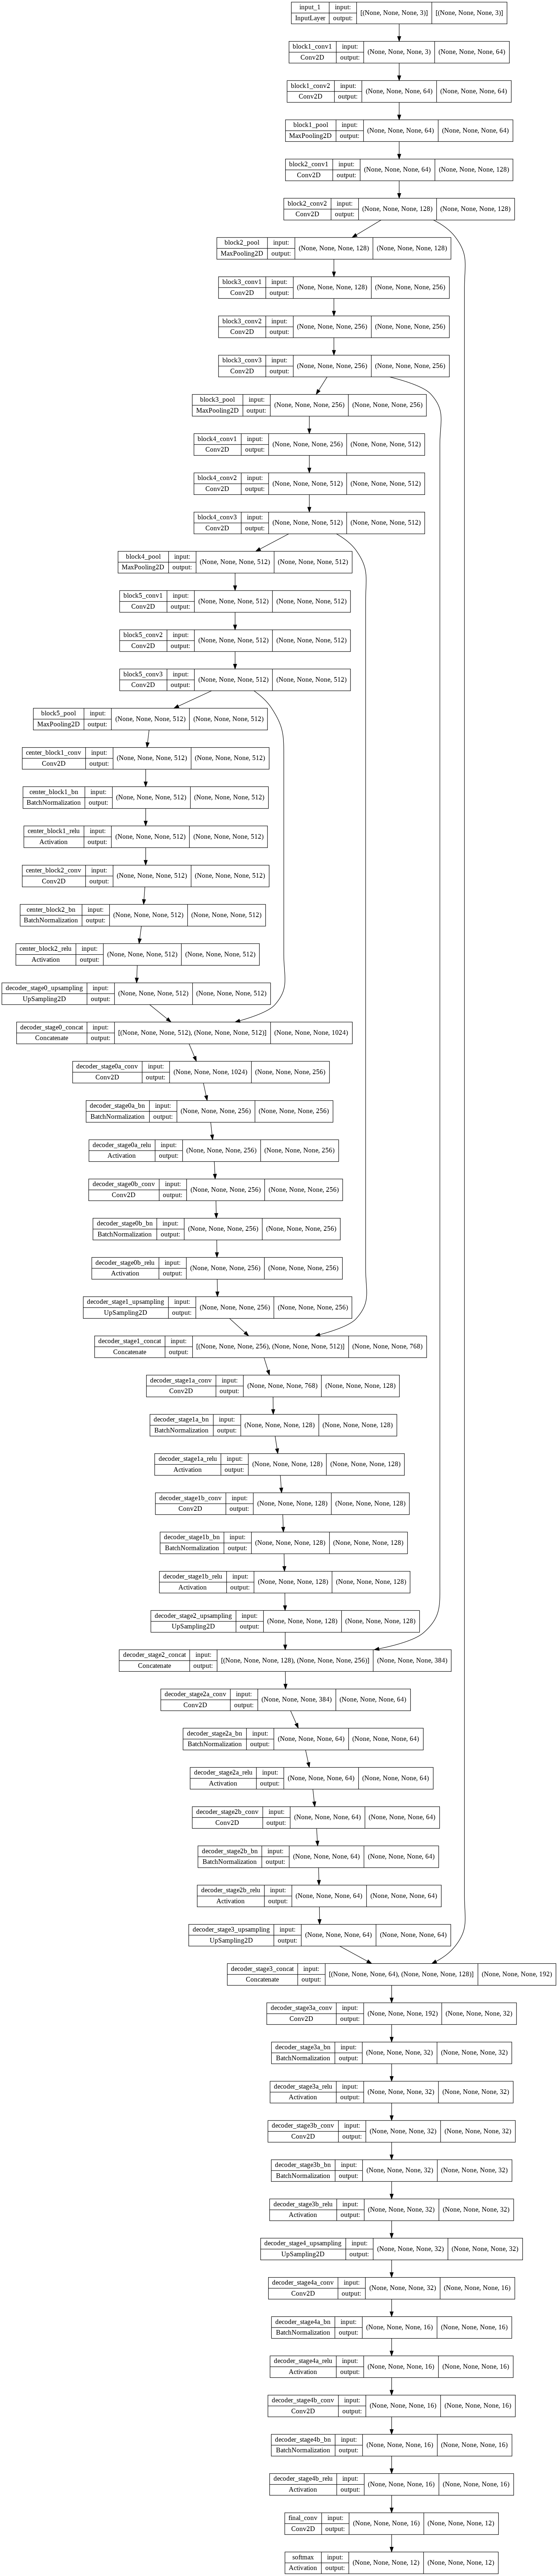

In [25]:
plot_model(model1, os.path.join(DATASET_PATH_GDRIVE,"unet_vgg16.png"), show_shapes=True)

##Model Training <a name="train1"></a>

In [26]:
M1 = model1.fit(
    x = x_train,
    y = y_train_OHE,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_val, y_val_OHE),
    callbacks = callbacks
)

Epoch 1/40
19/19 [==============================] - 44s 1s/step - loss: 0.8238 - dice_coef: 0.1788 - accuracy: 0.3691 - tp: 1105043.0000 - fp: 135833.0000 - tn: 211813488.0000 - fn: 18156660.0000 - val_loss: 0.8196 - val_dice_coef: 0.1757 - val_accuracy: 0.1676 - val_tp: 737573.0000 - val_fp: 2251955.0000 - val_tn: 50374744.0000 - val_fn: 4045266.0000 - lr: 1.0000e-04
Epoch 2/40
19/19 [==============================] - 9s 470ms/step - loss: 0.7196 - dice_coef: 0.2820 - accuracy: 0.4765 - tp: 5401483.0000 - fp: 238005.0000 - tn: 211711312.0000 - fn: 13860218.0000 - val_loss: 0.8068 - val_dice_coef: 0.1890 - val_accuracy: 0.2165 - val_tp: 734209.0000 - val_fp: 1541479.0000 - val_tn: 51085216.0000 - val_fn: 4048630.0000 - lr: 1.0000e-04
Epoch 3/40
19/19 [==============================] - 10s 510ms/step - loss: 0.6506 - dice_coef: 0.3503 - accuracy: 0.5475 - tp: 6964501.0000 - fp: 376634.0000 - tn: 211572672.0000 - fn: 12297200.0000 - val_loss: 0.7814 - val_dice_coef: 0.2155 - val_accuracy

##Learning Curve Plots <a name="plot1"></a>

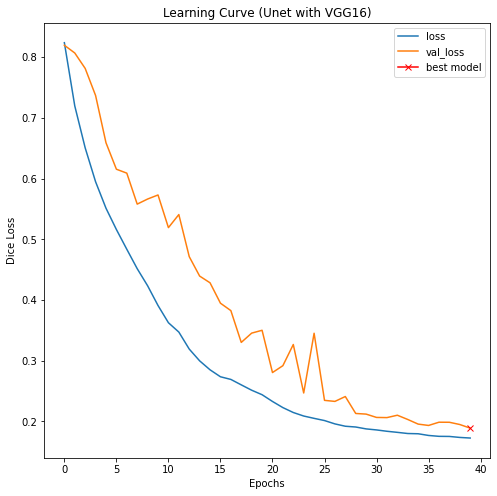

<Figure size 432x288 with 0 Axes>

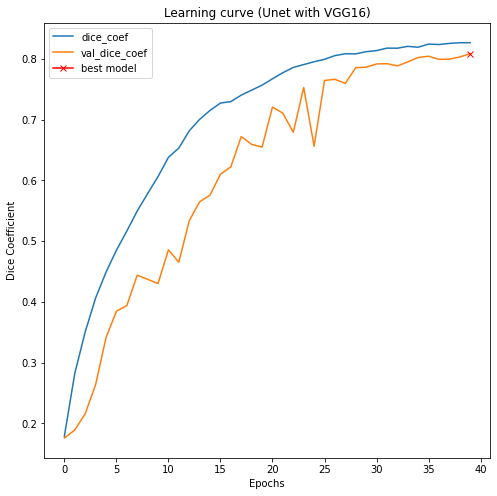

<Figure size 432x288 with 0 Axes>

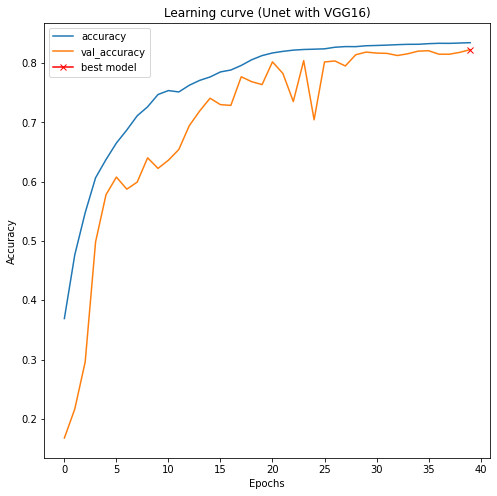

<Figure size 432x288 with 0 Axes>

In [27]:
plt.figure(figsize=(8, 8))
plt.title("Learning Curve (Unet with VGG16)")
plt.plot(M1.history["loss"], label="loss")
plt.plot(M1.history["val_loss"], label="val_loss")
plt.plot( np.argmin(M1.history["val_loss"]), np.min(M1.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Dice Loss")
plt.legend();
plt.show()
plt.savefig(os.path.join(DATASET_PATH_GDRIVE,'train_loss_unet_vgg16.png'))

plt.figure(figsize=(8, 8))
plt.title("Learning curve (Unet with VGG16)")
plt.plot(M1.history["dice_coef"], label="dice_coef")
plt.plot(M1.history["val_dice_coef"], label="val_dice_coef")
plt.plot(np.argmax(M1.history["val_dice_coef"]), np.max(M1.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend();
plt.show()
plt.savefig(os.path.join(DATASET_PATH_GDRIVE,'train_dice_coef_unet_vgg16.png'))

plt.figure(figsize=(8, 8))
plt.title("Learning curve (Unet with VGG16)")
plt.plot(M1.history["accuracy"], label="accuracy")
plt.plot(M1.history["val_accuracy"], label="val_accuracy")
plt.plot(np.argmax(M1.history["val_dice_coef"]), np.max(M1.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
plt.show()
plt.savefig(os.path.join(DATASET_PATH_GDRIVE,'train_accuracy_unet_vgg16.png'))

In [28]:
# Saving the model
model1.save(os.path.join(DATASET_PATH_GDRIVE,'unet_vgg16.h5'))

# Saving the model weights
model1.save_weights(os.path.join(DATASET_PATH_GDRIVE,'unet_vgg16_weights.h5'))

##Model Predictions <a name="pred1"></a>

In [29]:
pred1 = model1.predict(x_test, verbose= 1)

4/4 [==============================] - 13s 1s/step


##Performance Metrics <a name="pm1"></a>

In [30]:
eval1 = model1.evaluate(x_test, y_test_OHE, verbose=1)
values1 = []
for name, value in zip(model1.metrics_names, eval1):
  print(name, ': ', value)
  values1.append(value)
print()

# plot_cm(test_labels, test_predictions_weighted)


4/4 [==============================] - 1s 197ms/step - loss: 0.2248 - dice_coef: 0.7788 - accuracy: 0.7837 - tp: 5130897.0000 - fp: 698448.0000 - tn: 72113384.0000 - fn: 1486907.0000
loss :  0.22476309537887573
dice_coef :  0.7787873148918152
accuracy :  0.7836536169052124
tp :  5130897.0
fp :  698448.0
tn :  72113384.0
fn :  1486907.0



In [32]:
print(values1)

[0.22476309537887573, 0.7787873148918152, 0.7836536169052124, 5130897.0, 698448.0, 72113384.0, 1486907.0]


In [33]:
TP = values1[3]
FP = values1[4]
TN = values1[5]
FN = values1[6]

In [34]:
TPR, TNR, PPV, NPV, _, __, ___ = ComputePerformanceMetrics(TP,FP,TN,FN)
PerformanceMetrics(TPR,TNR,PPV,NPV)

-----------------------
TPR:     0.7753
TNR:     0.9904
PPV:     0.8802
NPV:     0.9798
-----------------------


##Qualitative Results <a name="pm1"></a>

In [35]:
pred1_ = np.argmax(pred1, axis=-1)

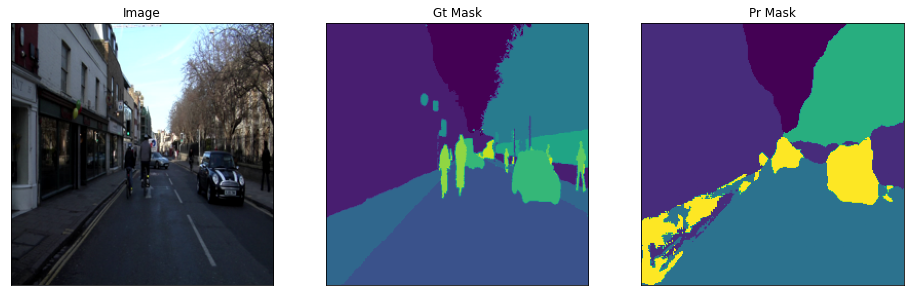

In [36]:
visualize(
        image=denormalize(x_test[0].squeeze()),
        gt_mask=y_test[0].squeeze(),
        pr_mask=pred1_[0].squeeze(),
    )

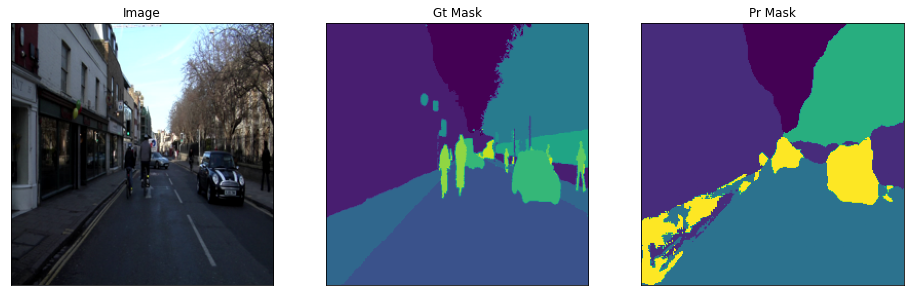

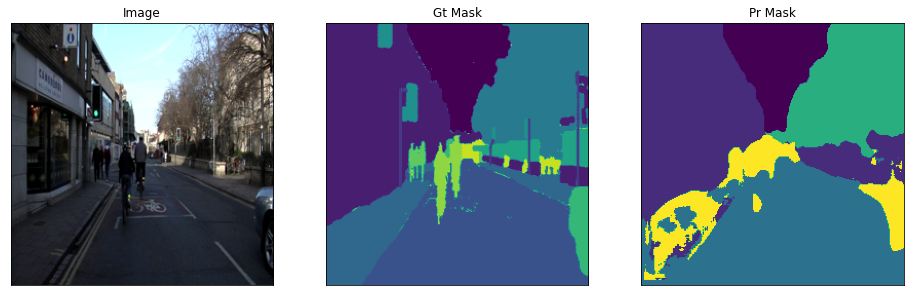

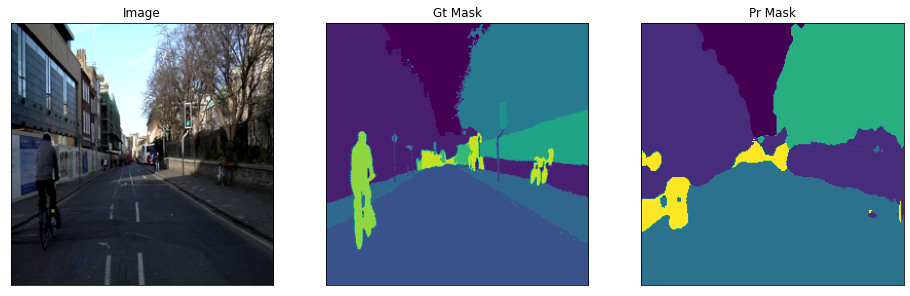

In [63]:
ids = [0, 50, 100]
for i in ids:
  
    visualize(
        image = denormalize(x_test[i].squeeze()),
        gt_mask = y_test[i].squeeze(),
        pr_mask = pred1_[i].squeeze(),
    )

##UNet with ResNet50 <a name="ResNet"></a>

In [37]:
BATCH_SIZE = 16
EPOCHS = 40
LR = 0.0001
# Height and Width set to 256, in helper functions (used to fetch images)

In [38]:
BACKBONE = 'resnet50'
#create model with ResNet50 backbone and pre-trained imagenet weights
model2 = sm.Unet(BACKBONE, classes=len(CLASSES)+1, activation='softmax', encoder_weights='imagenet',  decoder_use_batchnorm=True)

94601216/94592056 [==============================] - 3s 0us/step


In [39]:
model2.compile(
    optimizer = Adam(learning_rate=LR, amsgrad=True),
    loss = dice_loss,
    metrics = [
               dice_coef,
               'accuracy',
               keras.metrics.TruePositives(name='tp'),
               keras.metrics.FalsePositives(name='fp'),
               keras.metrics.TrueNegatives(name='tn'),
               keras.metrics.FalseNegatives(name='fn')
               ]
    )
callbacks = [
             ModelCheckpoint(os.path.join(DATASET_PATH_GDRIVE,'model_unet_resnet50.h5'), monitor='val_dice_coef', mode='max', save_weights_only=True, save_best_only=True),
             CSVLogger(os.path.join(DATASET_PATH_GDRIVE,'train_logs_unet_resnet50.csv')),    
             ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
             ]

In [40]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

##Model Architecture <a name="img2"></a>

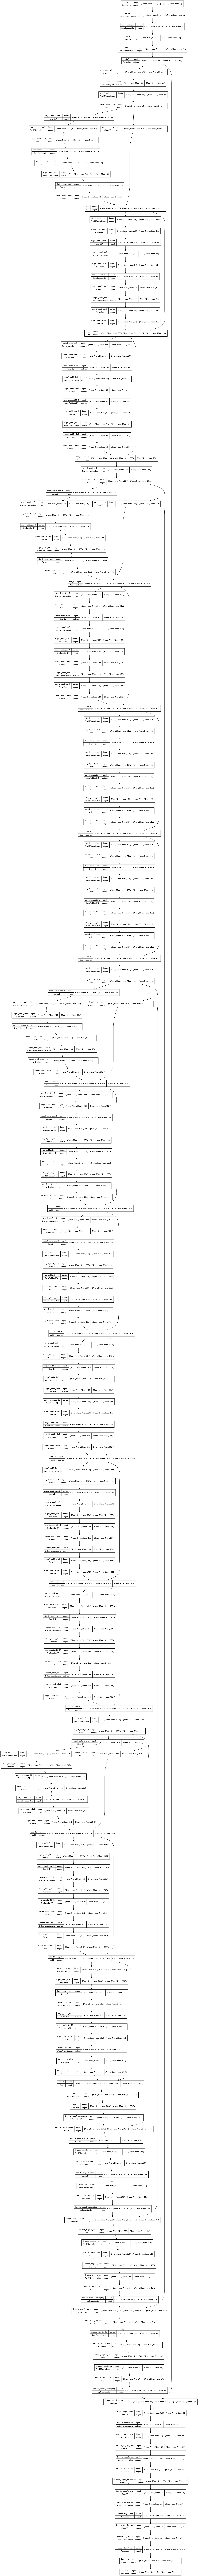

In [41]:
plot_model(model2, os.path.join(DATASET_PATH_GDRIVE,"unet_resnet50.png"), show_shapes=True)

In [ ]:
# unet_model.compile(
#     optimizer = Adam(learning_rate=LR, amsgrad=True),
#     loss = dice_loss, 
#     metrics = dice_coef
#     )

# callbacks = [
#              ModelCheckpoint(os.path.join(DATASET_PATH_LOCAL,'/best_model.h5'), save_weights_only=True, save_best_only=True),
#              CSVLogger(os.path.join(DATASET_PATH_LOCAL,'train_logs_unet.csv')),    
#              ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
#              ]

In [ ]:
# # define optomizer
# optim = Adam(learning_rate=0.0001, amsgrad=True)

# # # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# # # set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
# # dice_loss = sm.losses.DiceLoss() 
# # # dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
# # focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# # total_loss = dice_loss + (1 * focal_loss)

# # # actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# # # total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 
# total_loss = [dice_loss,jaccard_distance_loss]
# # metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
# metrics = [dice_coef,iou_coef]

# # compile keras model with defined optimozer, loss and metrics
# model.compile(optim, total_loss, metrics)

# # define callbacks for learning rate scheduling and best checkpoints saving
# callbacks = [
#              ModelCheckpoint(os.path.join(DATASET_PATH_LOCAL,'/best_model.h5'), save_weights_only=True, save_best_only=True),
#              CSVLogger(os.path.join(DATASET_PATH_LOCAL,'train_logs_unet.csv')),    
#              ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
#              ]

##Model Training <a name="train2"></a>

In [42]:
M2 = model2.fit(
    x = x_train,
    y = y_train_OHE,
    batch_size = BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val_OHE),
    callbacks = callbacks
)

Epoch 1/40
19/19 [==============================] - 26s 829ms/step - loss: 0.8073 - dice_coef: 0.1951 - accuracy: 0.3663 - tp: 1916105.0000 - fp: 137048.0000 - tn: 211812272.0000 - fn: 17345596.0000 - val_loss: 0.7504 - val_dice_coef: 0.2492 - val_accuracy: 0.3958 - val_tp: 1002822.0000 - val_fp: 139175.0000 - val_tn: 52487520.0000 - val_fn: 3780017.0000 - lr: 1.0000e-04
Epoch 2/40
19/19 [==============================] - 9s 468ms/step - loss: 0.6762 - dice_coef: 0.3247 - accuracy: 0.5724 - tp: 6074306.0000 - fp: 280210.0000 - tn: 211669104.0000 - fn: 13187395.0000 - val_loss: 0.6369 - val_dice_coef: 0.3629 - val_accuracy: 0.5293 - val_tp: 1551157.0000 - val_fp: 280716.0000 - val_tn: 52345980.0000 - val_fn: 3231682.0000 - lr: 1.0000e-04
Epoch 3/40
19/19 [==============================] - 8s 430ms/step - loss: 0.6014 - dice_coef: 0.3991 - accuracy: 0.6123 - tp: 8945806.0000 - fp: 520495.0000 - tn: 211428832.0000 - fn: 10315895.0000 - val_loss: 0.6836 - val_dice_coef: 0.3157 - val_accura

In [43]:
# Saving the model
model2.save(os.path.join(DATASET_PATH_GDRIVE,'unet_resnet50.h5'))

# Saving the model weights
model2.save_weights(os.path.join(DATASET_PATH_GDRIVE,'unet_resnet50_weights.h5'))

##Learning Curve Plots <a name="plot2"></a>

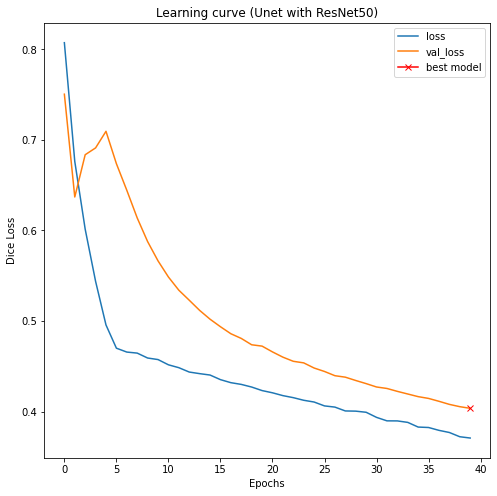

<Figure size 432x288 with 0 Axes>

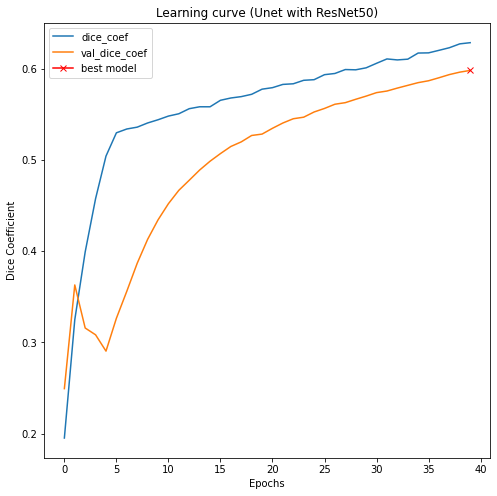

<Figure size 432x288 with 0 Axes>

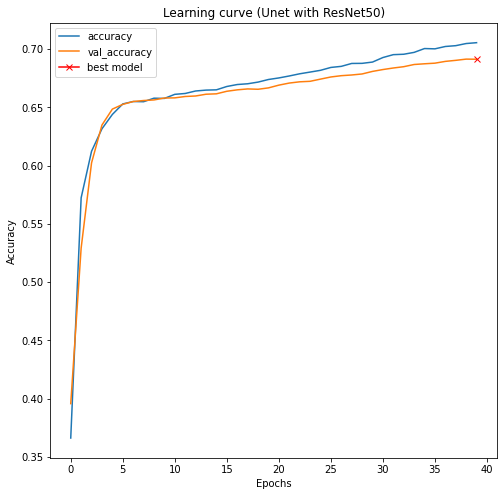

<Figure size 432x288 with 0 Axes>

In [44]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve (Unet with ResNet50)")
plt.plot(M2.history["loss"], label="loss")
plt.plot(M2.history["val_loss"], label="val_loss")
plt.plot( np.argmin(M2.history["val_loss"]), np.min(M2.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Dice Loss")
plt.legend();
plt.show()
plt.savefig(os.path.join(DATASET_PATH_GDRIVE,'train_loss_unet_resnet50.png'))

plt.figure(figsize=(8, 8))
plt.title("Learning curve (Unet with ResNet50)")
plt.plot(M2.history["dice_coef"], label="dice_coef")
plt.plot(M2.history["val_dice_coef"], label="val_dice_coef")
plt.plot(np.argmax(M2.history["val_dice_coef"]), np.max(M2.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend();
plt.show()
plt.savefig(os.path.join(DATASET_PATH_GDRIVE,'train_dice_coef_unet_resnet50.png'))

plt.figure(figsize=(8, 8))
plt.title("Learning curve (Unet with ResNet50)")
plt.plot(M2.history["accuracy"], label="accuracy")
plt.plot(M2.history["val_accuracy"], label="val_accuracy")
plt.plot(np.argmax(M2.history["val_dice_coef"]), np.max(M2.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
plt.show()
plt.savefig(os.path.join(DATASET_PATH_GDRIVE,'train_accuracy_unet_resnet50.png'))

##Model Predictions <a name="pred1"></a>

In [45]:
pred2 = model2.predict(x_test, verbose= 1)

4/4 [==============================] - 4s 451ms/step


##Performance Metrics <a name="pm1"></a>

In [46]:
eval2 = model2.evaluate(x_test, y_test_OHE, verbose=1)
values2 = []
for name, value in zip(model2.metrics_names, eval2):
  print(name, ': ', value)
  values2.append(value)
print()

4/4 [==============================] - 1s 182ms/step - loss: 0.3665 - dice_coef: 0.6331 - accuracy: 0.7579 - tp: 4679836.0000 - fp: 318273.0000 - tn: 72493552.0000 - fn: 1937968.0000
loss :  0.36650511622428894
dice_coef :  0.6330846548080444
accuracy :  0.7578588724136353
tp :  4679836.0
fp :  318273.0
tn :  72493552.0
fn :  1937968.0



In [47]:
print(values2)

[0.36650511622428894, 0.6330846548080444, 0.7578588724136353, 4679836.0, 318273.0, 72493552.0, 1937968.0]


In [48]:
TP = values2[3]
FP = values2[4]
TN = values2[5]
FN = values2[6]

In [49]:
TPR, TNR, PPV, NPV, _, __, ___ = ComputePerformanceMetrics(TP,FP,TN,FN)
PerformanceMetrics(TPR,TNR,PPV,NPV)

-----------------------
TPR:     0.7072
TNR:     0.9956
PPV:     0.9363
NPV:     0.9740
-----------------------


##Qualitative Results <a name="pm1"></a>

In [50]:
pred2_ = np.argmax(pred2, axis=-1)

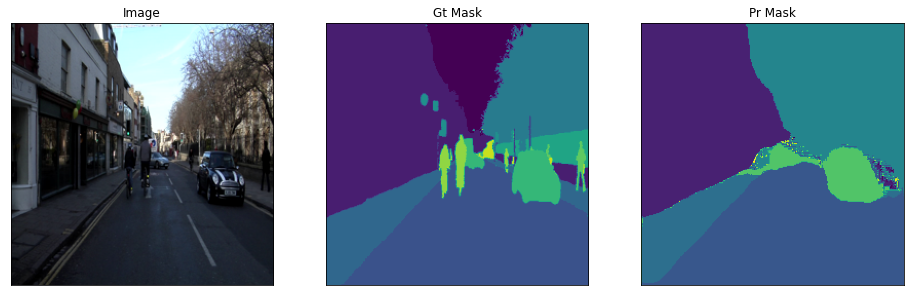

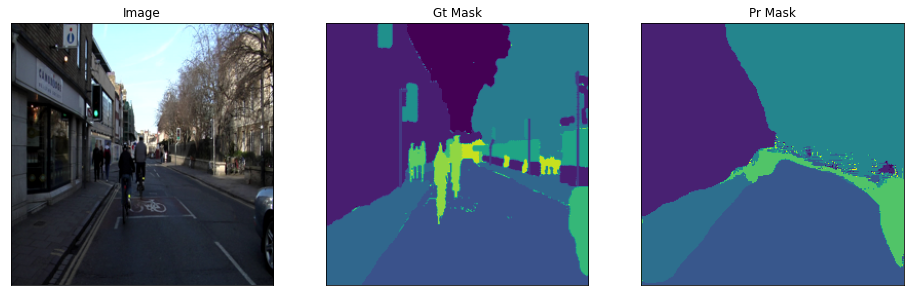

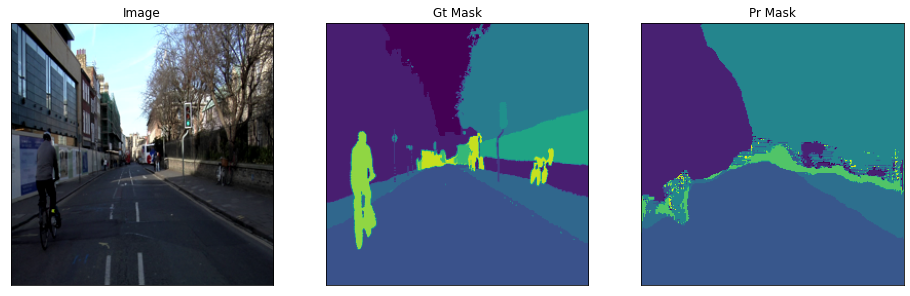

In [62]:
ids =[ 0, 50, 100]
for i in ids:
  
    visualize(
        image = denormalize(x_test[i].squeeze()),
        gt_mask = y_test[i].squeeze(),
        pr_mask = pred2_[i].squeeze(),
    )